<a href="https://colab.research.google.com/github/PUBPOL-2130/notebooks/blob/main/helper-notebooks/PracticeGeolocating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Practice Geolocating Data

In this notebook, we'll practice geocoding and geolocating data using the [Census Geocoder](https://geocoding.geo.census.gov/geocoder/). The Census Geocoder is a free tool that you can use to Geocode addresses in the United States, Puerto Rico, and the U.S. Island Areas. It does have an [API](https://geocoding.geo.census.gov/geocoder/Geocoding_Services_API.html), so you can geocode addresses programmatically within a Jupyter notebook. In contrast to other services, like the [Google Maps Geocoding API](https://developers.google.com/maps/documentation/geocoding/overview), it is completely free.

* **Geocoding** is the specific process of converting address information into lat/long coordinates.
* **Reverse geocoding** is the process of identifying a location (e.g., an address) based on the lat/long coordinates.
* **Gelocating** is the more general process of assigning a spatial location to points.

There are several Python packages that can be useful tools for interacting more easily with the Census Geocoder (e.g., [U.S. Census Geocoder](https://census-geocoder.readthedocs.io/en/latest/index.html), [censusgeocoder](https://pypi.org/project/censusgeocode/), and [censusbatchgeocoder](https://github.com/palewire/censusbatchgeocoder?tab=readme-ov-file)). Try exploring these Python packages on your own to see if they suit your needs.

However, in this notebook, we will submit individual and batch geocoding requests to the Census Geocoder API directly, so that understand what's involved in the process. The resulting code is much more complex and clunky; available Python packages will simplify the process.

In [3]:
pip install -q us

In [4]:
import requests, zipfile, io
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import us

##Load Data

First, we'll load data on [New York State hospitals](https://health.data.ny.gov/Health/Hospital-Profile/7a62-tptu/about_data), available from the New York State Open Data portal. We'll do this by unzipping a zip file containing several Excel sheets.

In [5]:
url = "https://health.data.ny.gov/download/7a62-tptu/application%2Fx-zip-compressed"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

Let's focus on the information about the hospital locations, which is given to us as an address. This kind of information is exactly the kind of use case for geocoding.

In [6]:
df_hospitals = pd.read_excel("Entity_Hospitals_Q1_2023.xls")
df_hospitals.head()

,Entity ID,Name,PFI,Address,City,State,Zipcode,Phone Number,Regional Office,OPCERT
0,102952,A.O. Fox Memorial Hospital,739.0,One Norton Avenue,Oneonta,NY,13820,6074322000,Capital District,3801000H
1,102913,A.O. Fox Memorial Hospital - Tri-Town Campus,8554.0,43 Pearl Street West,Sidney,NY,13838,6075612021,Capital District,3801000H
2,225776,Adirondack Medical Center-Lake Placid Site,306.0,203 Old Military Road,Lake Placid,NY,12946,5185233311,Capital District,1623001H
3,102949,Adirondack Medical Center-Saranac Lake Site,324.0,"2233 State Route 86, P.O. Box 471",Saranac Lake,NY,12983,5188914141,Capital District,1623001H
4,103004,Albany Medical Center - South Clinical Campus,2.0,25 Hackett Boulevard,Albany,NY,12208,5182621200,Capital District,0101000H


##Individual Geocoding Requests

The simplest way to use the Census geocoder is to submit an individual (or, single record) geocoding request. We will start with a location search, which just returns the matched address and the lat/long coordinates.

*Note:* we need to specify a parameter called benchmark, which refers to the version of the locater that we should use. We will use benchmark ID 4, corresponding to "Public Address Ranges - Current Benchmark."

In [7]:
# we only will return the location
returntype = "locations"
# we will submit the address as one line
searchtype = "onelineaddress"

# define search parameters
parameters = {
    "address": "One Norton Avenue Oneonta, NY 13820",
    "benchmark": 4,
    "format": "jsonp",
}

# set the api endpoint
url = f"http://geocoding.geo.census.gov/geocoder/{returntype}/{searchtype}"

# download data via post request
r = requests.post(url, params=parameters)

# convert to json
r_json = json.loads(r.text)
r_json

{'result': {'input': {'address': {'address': 'One Norton Avenue Oneonta, NY 13820'},
   'benchmark': {'isDefault': True,
    'benchmarkDescription': 'Public Address Ranges - Current Benchmark',
    'id': '4',
    'benchmarkName': 'Public_AR_Current'}},
  'addressMatches': [{'tigerLine': {'side': 'L', 'tigerLineId': '125917742'},
    'coordinates': {'x': -75.053273913257, 'y': 42.457406466038},
    'addressComponents': {'zip': '13820',
     'streetName': 'NORTON',
     'preType': '',
     'city': 'ONEONTA',
     'preDirection': '',
     'suffixDirection': '',
     'fromAddress': '1',
     'state': 'NY',
     'suffixType': 'AVE',
     'toAddress': '99',
     'suffixQualifier': '',
     'preQualifier': ''},
    'matchedAddress': '1 NORTON AVE, ONEONTA, NY, 13820'}]}}

In [8]:
# now we can view the matched address
r_json["result"]["addressMatches"]

[{'tigerLine': {'side': 'L', 'tigerLineId': '125917742'},
  'coordinates': {'x': -75.053273913257, 'y': 42.457406466038},
  'addressComponents': {'zip': '13820',
   'streetName': 'NORTON',
   'preType': '',
   'city': 'ONEONTA',
   'preDirection': '',
   'suffixDirection': '',
   'fromAddress': '1',
   'state': 'NY',
   'suffixType': 'AVE',
   'toAddress': '99',
   'suffixQualifier': '',
   'preQualifier': ''},
  'matchedAddress': '1 NORTON AVE, ONEONTA, NY, 13820'}]

In [9]:
# and extract the lat/long
r_json["result"]["addressMatches"][0]["coordinates"]

{'x': -75.053273913257, 'y': 42.457406466038}

Now, we can try a geographic search, which will return additional geographic information related to the returned lat/long coordinate.

*Note:* now we additionally need to specify a parameter called *vintage* and *layer.* The vintage is the census or survey data to which the geographic area is linked (e.g., Census 2010, ACS 2023, or Census 2020). The [*layer*](https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/tigerWMS_Current/MapServer) is the geographic layer that's returned, such as Census tract.

In [10]:
# we only will return the location
returntype = "geographies"
# we will submit the address as one line
searchtype = "onelineaddress"

# define search parameters
parameters = {
    "address": "One Norton Avenue Oneonta, NY 13820",
    "benchmark": 4,
    "format": "jsonp",
    "vintage": "Current_Current",
    "layers": 8,
}

# set the api endpoint
url = f"http://geocoding.geo.census.gov/geocoder/{returntype}/{searchtype}"

# download data via post request
r = requests.post(url, params=parameters)

# convert to json
r_json = json.loads(r.text)
r_json

{'result': {'input': {'address': {'address': 'One Norton Avenue Oneonta, NY 13820'},
   'vintage': {'isDefault': True,
    'id': '4',
    'vintageName': 'Current_Current',
    'vintageDescription': 'Current Vintage - Current Benchmark'},
   'benchmark': {'isDefault': True,
    'benchmarkDescription': 'Public Address Ranges - Current Benchmark',
    'id': '4',
    'benchmarkName': 'Public_AR_Current'}},
  'addressMatches': [{'tigerLine': {'side': 'L', 'tigerLineId': '125917742'},
    'geographies': {'Census Tracts': [{'GEOID': '36077590900',
       'CENTLAT': '+42.4566907',
       'AREAWATER': '0',
       'STATE': '36',
       'BASENAME': '5909',
       'OID': '20790734532303',
       'LSADC': 'CT',
       'FUNCSTAT': 'S',
       'INTPTLAT': '+42.4566907',
       'NAME': 'Census Tract 5909',
       'OBJECTID': 36768,
       'TRACT': '590900',
       'CENTLON': '-075.0459503',
       'AREALAND': '2842975',
       'INTPTLON': '-075.0459503',
       'MTFCC': 'G5020',
       'COUNTY': '077'

In [11]:
# now we can view the matched address
r_json["result"]["addressMatches"]

[{'tigerLine': {'side': 'L', 'tigerLineId': '125917742'},
  'geographies': {'Census Tracts': [{'GEOID': '36077590900',
     'CENTLAT': '+42.4566907',
     'AREAWATER': '0',
     'STATE': '36',
     'BASENAME': '5909',
     'OID': '20790734532303',
     'LSADC': 'CT',
     'FUNCSTAT': 'S',
     'INTPTLAT': '+42.4566907',
     'NAME': 'Census Tract 5909',
     'OBJECTID': 36768,
     'TRACT': '590900',
     'CENTLON': '-075.0459503',
     'AREALAND': '2842975',
     'INTPTLON': '-075.0459503',
     'MTFCC': 'G5020',
     'COUNTY': '077'}]},
  'coordinates': {'x': -75.053273913257, 'y': 42.457406466038},
  'addressComponents': {'zip': '13820',
   'streetName': 'NORTON',
   'preType': '',
   'city': 'ONEONTA',
   'preDirection': '',
   'suffixDirection': '',
   'fromAddress': '1',
   'state': 'NY',
   'suffixType': 'AVE',
   'toAddress': '99',
   'suffixQualifier': '',
   'preQualifier': ''},
  'matchedAddress': '1 NORTON AVE, ONEONTA, NY, 13820'}]

In [12]:
# we have an additional result that's returned for the Census geography we specified
r_json["result"]["addressMatches"][0]["geographies"]

{'Census Tracts': [{'GEOID': '36077590900',
   'CENTLAT': '+42.4566907',
   'AREAWATER': '0',
   'STATE': '36',
   'BASENAME': '5909',
   'OID': '20790734532303',
   'LSADC': 'CT',
   'FUNCSTAT': 'S',
   'INTPTLAT': '+42.4566907',
   'NAME': 'Census Tract 5909',
   'OBJECTID': 36768,
   'TRACT': '590900',
   'CENTLON': '-075.0459503',
   'AREALAND': '2842975',
   'INTPTLON': '-075.0459503',
   'MTFCC': 'G5020',
   'COUNTY': '077'}]}

##Batch Geocoding

Now we'll perform a batch geocoding operation, in which we will geocode all the addresses in our data at once. The Census geocoder can process up to 10,000 addresses at once. If you have more than 10,000 addresses, you'll have to submit them via separate API calls.

The CSV for the Census geocoder must be formatted in the following way:

* Unique ID
* Street address
* City
* State
* ZIP

We'll start by formatting our dataframe in this way.

In [13]:
# rename and subset columns
df_hospitals_clean = df_hospitals.rename(
    columns={"Entity ID": "Unique ID", "Address": "Street address", "Zipcode": "ZIP"}
)[["Unique ID", "Street address", "City", "State", "ZIP"]]

df_hospitals_clean["Street address"] = df_hospitals_clean["Street address"].str.replace(
    ",", "-"
)
# df_hospitals_clean['Street address'] = "'" + df_hospitals_clean['Street address'] + "'"
# view our data
df_hospitals_clean.head()

,Unique ID,Street address,City,State,ZIP
0,102952,One Norton Avenue,Oneonta,NY,13820
1,102913,43 Pearl Street West,Sidney,NY,13838
2,225776,203 Old Military Road,Lake Placid,NY,12946
3,102949,2233 State Route 86- P.O. Box 471,Saranac Lake,NY,12983
4,103004,25 Hackett Boulevard,Albany,NY,12208


In [14]:
# save to local csv for geocoding
df_hospitals_clean.to_csv("addresses.csv", index=False)

In [15]:
url = "https://geocoding.geo.census.gov/geocoder/geographies/addressbatch"
parameters = {
    "benchmark": "Public_AR_Current",
    "vintage": "Current_Current",
    "format": "json",
}
files = {"addressFile": ("addresses.csv", open(r"./addresses.csv", "rb"))}
r = requests.post(url, files=files, data=parameters)

In [16]:
# need to clean geocoded result, which is just a text string
# note: results do not have headers, so we will have to name the columns ourselves
# via the documentation
geocoded_lines_list = [
    x.replace('"', "").strip().split(",") for x in r.text.splitlines()
]
geocoded_df = pd.DataFrame(
    geocoded_lines_list,
    columns=[
        "Record ID Number",
        "Input Address",
        "Input City",
        "Input State",
        "Input Zip",
        "Match Indicator",
        "TIGER Match Type",
        "TIGER Output Street Address",
        "TIGER Output City",
        "TIGER Output State",
        "TIGER Output Zip",
        "Interpolated Longitude",
        "Interpolated Latitude",
        "Tigerline ID",
        "Tigerline ID Side",
        "State",
        "County",
        "Tract",
        "Block",
    ],
)
geocoded_df

,Record ID Number,Input Address,Input City,Input State,Input Zip,Match Indicator,TIGER Match Type,TIGER Output Street Address,TIGER Output City,TIGER Output State,TIGER Output Zip,Interpolated Longitude,Interpolated Latitude,Tigerline ID,Tigerline ID Side,State,County,Tract,Block
0,103052,70 Dubois Street,Newburgh,NY,12550,Match,Exact,70 DUBOIS ST,NEWBURGH,NY,12550,-74.01509741502,41.503660310543,124413636,R,36,071,000400,3008
1,103051,1001 WEST STREET,Carthage,NY,13619,Match,Exact,1001 WEST ST,CARTHAGE,NY,13619,-75.594812671823,43.986233106494,640586932,L,36,045,060902,2005
2,103054,1980 Crompond Road,Cortlandt Manor,NY,10567,Match,Exact,1980 CROMPOND RD,CORTLANDT MANOR,NY,10567,-73.892001247379,41.291447199115,139724641,L,36,119,014701,4011
3,103053,2 Coulter Road,Clifton Springs,NY,14432,Match,Exact,2 COULTER RD,CLIFTON SPRINGS,NY,14432,-77.138593472615,42.96053782119,605723285,R,36,069,050303,1018
4,103056,535 E 70th Street,New York,NY,10021,Match,Exact,535 E 70TH ST,NEW YORK,NY,10021,-73.95392738726,40.765284298935,640859609,L,36,061,012400,8001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,102941,621 TENTH STREET,Niagara Falls,NY,14302,Match,Non_Exact,621 10TH ST,NIAGARA FALLS,NY,14301,-79.05035073597,43.093469486821,48686157,R,36,063,021200,4007
221,102940,170 William Street,New York,NY,10038,Match,Exact,170 WILLIAM ST,NEW YORK,NY,10038,-74.005493041926,40.710404152638,59660425,R,36,061,001501,1013
222,102943,241 North Road,Poughkeepsie,NY,12601,Match,Exact,241 NORTH RD,POUGHKEEPSIE,NY,12601,-73.932736892906,41.7280185416,639390169,L,36,027,140101,2014
223,102945,127 North St,Batavia,NY,14020,Match,Exact,127 NORTH ST,BATAVIA,NY,14020,-78.177071258485,43.003978608118,48160264,R,36,037,950800,3013


In [17]:
geocoded_df = geocoded_df[geocoded_df["Interpolated Longitude"].notna()]

##Converting to Points

As our last step, we'll need to create a geodataframe out of the lat/long values that we have.

In [18]:
hospitals_gdf = gpd.GeoDataFrame(
    geocoded_df,
    geometry=gpd.points_from_xy(
        geocoded_df["Interpolated Longitude"], geocoded_df["Interpolated Latitude"]
    ),
    crs=4326,
)
hospitals_gdf.head()

,Record ID Number,Input Address,Input City,Input State,Input Zip,Match Indicator,TIGER Match Type,TIGER Output Street Address,TIGER Output City,TIGER Output State,TIGER Output Zip,Interpolated Longitude,Interpolated Latitude,Tigerline ID,Tigerline ID Side,State,County,Tract,Block,geometry
0,103052,70 Dubois Street,Newburgh,NY,12550,Match,Exact,70 DUBOIS ST,NEWBURGH,NY,12550,-74.01509741502,41.503660310543,124413636,R,36,071,000400,3008,POINT (-74.0151 41.50366)
1,103051,1001 WEST STREET,Carthage,NY,13619,Match,Exact,1001 WEST ST,CARTHAGE,NY,13619,-75.594812671823,43.986233106494,640586932,L,36,045,060902,2005,POINT (-75.59481 43.98623)
2,103054,1980 Crompond Road,Cortlandt Manor,NY,10567,Match,Exact,1980 CROMPOND RD,CORTLANDT MANOR,NY,10567,-73.892001247379,41.291447199115,139724641,L,36,119,014701,4011,POINT (-73.892 41.29145)
3,103053,2 Coulter Road,Clifton Springs,NY,14432,Match,Exact,2 COULTER RD,CLIFTON SPRINGS,NY,14432,-77.138593472615,42.96053782119,605723285,R,36,069,050303,1018,POINT (-77.13859 42.96054)
4,103056,535 E 70th Street,New York,NY,10021,Match,Exact,535 E 70TH ST,NEW YORK,NY,10021,-73.95392738726,40.765284298935,640859609,L,36,061,012400,8001,POINT (-73.95393 40.76528)


In [19]:
# load NY outline
NY_state_url = us.states.NY.shapefile_urls()
NY_gdf = gpd.read_file(NY_state_url["state"])

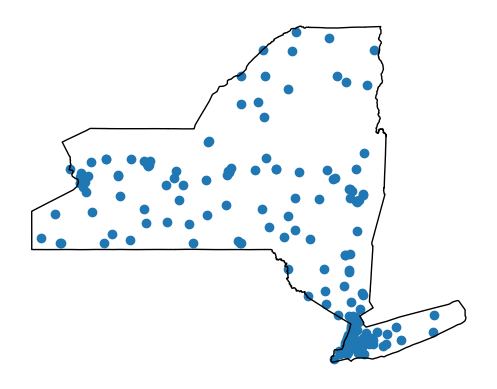

In [20]:
# plot hospitals
ax = hospitals_gdf.plot()
NY_gdf.plot(ax=ax, facecolor="none", edgecolor="black")
ax.set_axis_off();